In [3]:
%matplotlib inline

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import statistics
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn import tree
from sklearn.model_selection import GridSearchCV
import pydotplus 
from IPython.display import Image
from sklearn.metrics import classification_report
from sklearn import metrics
from sklearn.metrics import ConfusionMatrixDisplay, confusion_matrix
from sklearn.naive_bayes import GaussianNB
from sklearn.model_selection import cross_validate
from scikitplot.metrics import plot_roc

import seaborn as sn

sn.set_theme()

In [4]:
%%time
datasetPath = "../dataset/users_clean_with_indicators_no_outliers.h5"
df_users = pd.read_hdf(datasetPath)

CPU times: total: 15.6 ms
Wall time: 237 ms


<timed exec>:2: FutureWarning: In a future version, the Index constructor will not infer numeric dtypes when passed object-dtype sequences (matching Series behavior)


In [5]:
df_users

,name,lang,bot,created_at,statuses_count,tweet_count,retweet_made_ratio,reply_count_avg,favorite_count_avg,tweet_length_avg,num_special_chars_avg,elapsed_time_entropy,reply_count_entropy,favorite_count_entropy,num_hashtags_entropy,num_urls_entropy,num_mentions_entropy,tweet_length_entropy
2353593986,lamonica raborn,en,1,2019-02-22 18:00:42,76,120,0.000000,0.0,0.041667,62.366667,3.958333,1.364257,0.0,0.173205,0.304947,0.000000,0.603637,4.274598
2358850842,lourie botton,en,0,2019-02-26 03:02:32,54,104,0.000000,0.0,0.057692,69.961538,3.615385,1.335474,0.0,0.220570,0.130708,0.000000,0.656454,4.129301
137959629,dadan syarifudin,en,1,2015-04-30 07:09:56,3,3,0.000000,0.0,0.000000,17.333333,4.333333,0.693147,0.0,0.000000,0.000000,0.000000,0.000000,1.098612
466124818,carletto focia,it,1,2017-01-18 02:49:18,50,1275,0.004706,0.0,0.189020,88.509804,4.814118,4.130876,0.0,0.508540,0.252911,0.117266,0.036302,4.686233
2571493866,mbk ebook,en,0,2019-06-18 19:30:21,7085,3277,0.000000,0.0,0.064693,73.673482,3.671651,2.868727,0.0,0.243648,0.402308,0.007320,0.873255,4.765100
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2911861962,madrid lae maika .,en,0,2019-11-29 13:16:02,1126,1017,0.328417,0.0,0.060964,53.143559,5.085546,2.327531,0.0,0.229384,0.546803,0.126738,1.086588,4.701245
1378532629,clau sato,en,0,2018-04-27 03:01:58,3024,1888,0.106462,0.0,0.227225,60.895127,4.360699,3.268229,0.0,0.586425,0.395943,0.326282,0.964965,4.768169
126984069,alma leticia nuño,es,0,2015-03-29 17:01:24,6,6,0.000000,0.0,0.000000,67.666667,6.666667,1.332179,0.0,0.000000,0.636514,0.636514,0.636514,1.791759
2383025796,minnie guadagno,en,1,2019-03-13 02:44:13,42,96,0.000000,0.0,0.083333,64.572917,3.979167,1.256998,0.0,0.286836,0.057908,0.000000,0.671286,4.120230


In [6]:
df_users['bot'].value_counts(True)

1    0.531456
0    0.468544
Name: bot, dtype: float64

# Discretization phase

In [7]:
#function to discretize the variables
#input: the dataset and the list of variables' names to discretize
def discretize_data(dataset, variables):
    for variable in variables:
        #get the unique variable's values
        var = sorted(dataset[variable].unique())
        
        #generate a mapping from the variable's values to the number representation  
        mapping = dict(zip(var, range(0, len(var) + 1)))

        #add a new colum with the number representation of the variable
        dataset[variable+'_num'] = dataset[variable].map(mapping).astype(int)
    return dataset

In [8]:
#discretize the variable relationship, sex, occupation, marital-status, native-country, race
features_to_discretize = ['lang']
df_users_copy = df_users.copy()
df_users_classif = discretize_data(df_users_copy, features_to_discretize)
df_users_classif['created_at'] = df_users_classif.created_at.values.astype(np.int64)

In [9]:
df_users_classif.head(5)

,name,lang,bot,created_at,statuses_count,tweet_count,retweet_made_ratio,reply_count_avg,favorite_count_avg,tweet_length_avg,num_special_chars_avg,elapsed_time_entropy,reply_count_entropy,favorite_count_entropy,num_hashtags_entropy,num_urls_entropy,num_mentions_entropy,tweet_length_entropy,lang_num
2353593986,lamonica raborn,en,1,1550858442000000000,76,120,0.000000,0.0,0.041667,62.366667,3.958333,1.364257,0.0,0.173205,0.304947,0.000000,0.603637,4.274598,4
2358850842,lourie botton,en,0,1551150152000000000,54,104,0.000000,0.0,0.057692,69.961538,3.615385,1.335474,0.0,0.220570,0.130708,0.000000,0.656454,4.129301,4
137959629,dadan syarifudin,en,1,1430377796000000000,3,3,0.000000,0.0,0.000000,17.333333,4.333333,0.693147,0.0,0.000000,0.000000,0.000000,0.000000,1.098612,4
466124818,carletto focia,it,1,1484707758000000000,50,1275,0.004706,0.0,0.189020,88.509804,4.814118,4.130876,0.0,0.508540,0.252911,0.117266,0.036302,4.686233,9
2571493866,mbk ebook,en,0,1560886221000000000,7085,3277,0.000000,0.0,0.064693,73.673482,3.671651,2.868727,0.0,0.243648,0.402308,0.007320,0.873255,4.765100,4


In [10]:
#drop the categorical variables since we don't need them anymore
features_to_drop = ['lang', 'name']
df_users_classif.drop(columns=features_to_drop, axis=1, inplace=True)

In [11]:
df_users_classif.head(5)

,bot,created_at,statuses_count,tweet_count,retweet_made_ratio,reply_count_avg,favorite_count_avg,tweet_length_avg,num_special_chars_avg,elapsed_time_entropy,reply_count_entropy,favorite_count_entropy,num_hashtags_entropy,num_urls_entropy,num_mentions_entropy,tweet_length_entropy,lang_num
2353593986,1,1550858442000000000,76,120,0.000000,0.0,0.041667,62.366667,3.958333,1.364257,0.0,0.173205,0.304947,0.000000,0.603637,4.274598,4
2358850842,0,1551150152000000000,54,104,0.000000,0.0,0.057692,69.961538,3.615385,1.335474,0.0,0.220570,0.130708,0.000000,0.656454,4.129301,4
137959629,1,1430377796000000000,3,3,0.000000,0.0,0.000000,17.333333,4.333333,0.693147,0.0,0.000000,0.000000,0.000000,0.000000,1.098612,4
466124818,1,1484707758000000000,50,1275,0.004706,0.0,0.189020,88.509804,4.814118,4.130876,0.0,0.508540,0.252911,0.117266,0.036302,4.686233,9
2571493866,0,1560886221000000000,7085,3277,0.000000,0.0,0.064693,73.673482,3.671651,2.868727,0.0,0.243648,0.402308,0.007320,0.873255,4.765100,4


In [12]:
def print_metrics(train_label, test_label, train_pred, test_pred):
    #evaluate the accuracy on the train set and the test set
    #metrics also contains precision, recall, f1 and the support
    print('Accuracy train set', metrics.accuracy_score(train_label, train_pred))
    print('Accuracy test set', metrics.accuracy_score(test_label, test_pred))
    print('Precision train set', metrics.precision_score(train_label, train_pred, average='weighted'))
    print('Recall train set', metrics.recall_score(train_label, train_pred, average='weighted'))
    print('F1 score train set', metrics.f1_score(train_label, train_pred, average='weighted'))
    print('Support train set', metrics.precision_recall_fscore_support(train_label, train_pred))

#metrics computed on the test set
def report_scores(test_label, test_pred):
    print(classification_report(test_label, test_pred, target_names=['non-bot', 'bot']))

In [13]:
def run_greedy_gridsearch(grid, dataset: pd.DataFrame):
    for column in dataset:
        dataset_copy = dataset.copy()
        print("Running decision tree without the column '", column,"'")
        dataset_copy.drop(columns=[column], inplace=True)
        print("Columns:", dataset_copy.columns)
        
        train_set, test_set, train_label, test_label = train_test_split(dataset_copy, label, stratify =label, test_size=0.30, random_state=20)

        grid.fit(train_set.values, train_label)
        print("The best parameters are ", grid.best_params_, ", score: %0.5f"% (grid.best_score_))
        print("----------------------")
        print()

# Classification with Decision Tree

In [16]:
from sklearn.model_selection import train_test_split
label = df_users_classif.pop('bot')
train_set, test_set, train_label, test_label = train_test_split(df_users_classif, label, stratify =label, test_size=0.30, random_state=20)

In [20]:
param_grid = {
              'min_samples_split': [2, 3, 4],
              'min_samples_leaf': [1, 2, 3, 4],
              'criterion': ['gini', 'entropy'],
              'max_depth': [5, 6, 7, 9, 10]
             }


dt = tree.DecisionTreeClassifier()

grid = GridSearchCV(
    dt,
    param_grid,
    cv=3,
    scoring='accuracy',
    return_train_score=False,
    n_jobs=-1,
    verbose=1
)

grid.fit(train_set.values, train_label)
print("The best parameters are ", grid.best_params_, ", score: %0.5f"% (grid.best_score_))

Fitting 3 folds for each of 120 candidates, totalling 360 fits
The best parameters are  {'criterion': 'entropy', 'max_depth': 7, 'min_samples_leaf': 4, 'min_samples_split': 2} , score: 0.84631


In [21]:
dt = grid.best_estimator_
dt

DecisionTreeClassifier(criterion='entropy', max_depth=7, min_samples_leaf=4)

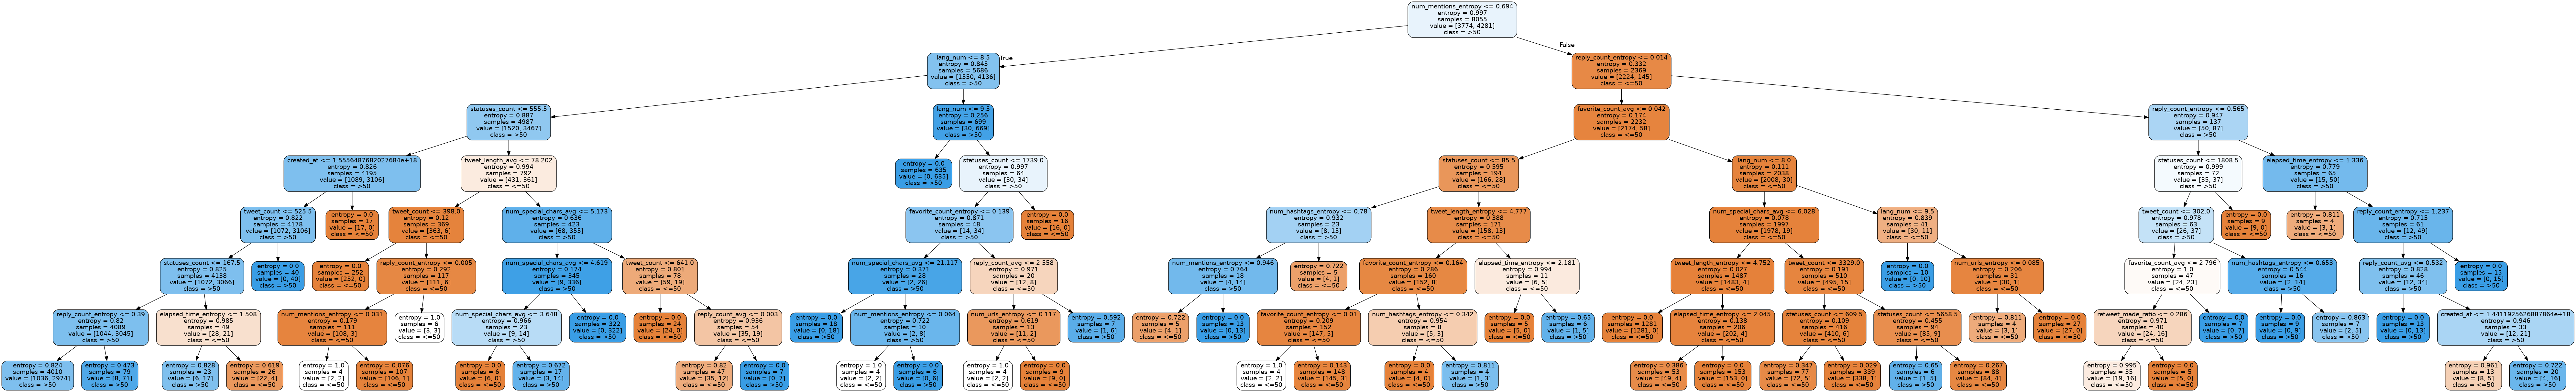

In [22]:
#visualize the actual decision tree obtained 
dot_data = tree.export_graphviz(dt, out_file=None, 
                         feature_names=list(train_set.columns),  
                         class_names=['<=50', '>50'],  
                         filled=True, rounded=True)  
graph = pydotplus.graph_from_dot_data(dot_data)  
Image(graph.create_png())

In [23]:
#predict using the decision tree
#the predict function returns the actual predicted labels: we need them for the evaluation phase
train_pred_dt = dt.predict(train_set)
test_pred_dt = dt.predict(test_set)

/home/dferraro/.local/lib/python3.10/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but DecisionTreeClassifier was fitted without feature names
  warnings.warn(
/home/dferraro/.local/lib/python3.10/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but DecisionTreeClassifier was fitted without feature names
  warnings.warn(


In [24]:
print_metrics(train_label, test_label, train_pred_dt, test_pred_dt)

Accuracy train set 0.8593420235878336
Accuracy test set 0.8415870257746887
Precision train set 0.8810861958139502
Recall train set 0.8593420235878336
F1 score train set 0.8559969822798987
Support train set (array([0.9748292, 0.7984452]), array([0.71833598, 0.98364868]), array([0.82715484, 0.88142334]), array([3774, 4281]))


In [25]:
report_scores(test_label, test_pred_dt)

              precision    recall  f1-score   support

        <=50       0.96      0.69      0.80      1618
         >50       0.78      0.97      0.87      1835

    accuracy                           0.84      3453
   macro avg       0.87      0.83      0.84      3453
weighted avg       0.86      0.84      0.84      3453



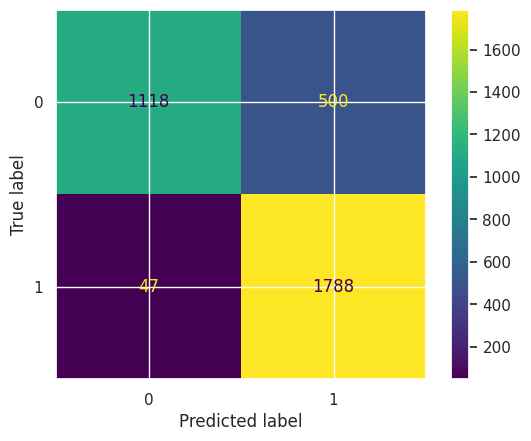

In [26]:
predictions = dt.predict(test_set.values)

cm = confusion_matrix(test_label, predictions)
disp = ConfusionMatrixDisplay(confusion_matrix = cm)
disp.plot()
plt.show()

/home/dferraro/.local/lib/python3.10/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but DecisionTreeClassifier was fitted without feature names
  warnings.warn(


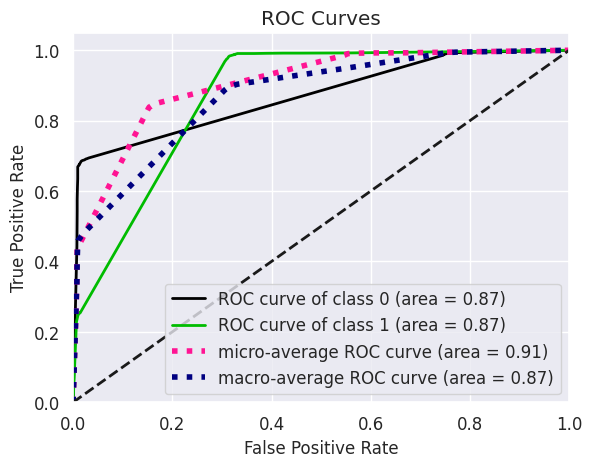

In [86]:
plot_roc(test_label, dt.predict_proba(test_set))
plt.show()

# Classification with Naive Bayes

In [80]:
scaler = StandardScaler()

train_set_std = scaler.fit_transform(train_set.values)
test_set_std = scaler.fit_transform(test_set.values)

In [81]:
gnb = GaussianNB()
gnb.fit(train_set_std, train_label)

#predict on the test set
test_pred_gnb = gnb.predict(test_set_std)
train_pred_gnb = gnb.predict(train_set_std)

In [82]:
print_metrics(train_label, test_label, train_pred_gnb, test_pred_gnb)

Accuracy train set 0.7694599627560521
Accuracy test set 0.7732406602953953
Precision train set 0.7821967554820207
Recall train set 0.7694599627560521
F1 score train set 0.7643664145694783
Support train set (array([0.83953241, 0.73165138]), array([0.62798092, 0.8941836 ]), array([0.71850841, 0.80479344]), array([3774, 4281]))


In [83]:
report_scores(test_label, test_pred_gnb)

              precision    recall  f1-score   support

        <=50       0.86      0.62      0.72      1618
         >50       0.73      0.91      0.81      1835

    accuracy                           0.77      3453
   macro avg       0.79      0.76      0.76      3453
weighted avg       0.79      0.77      0.77      3453



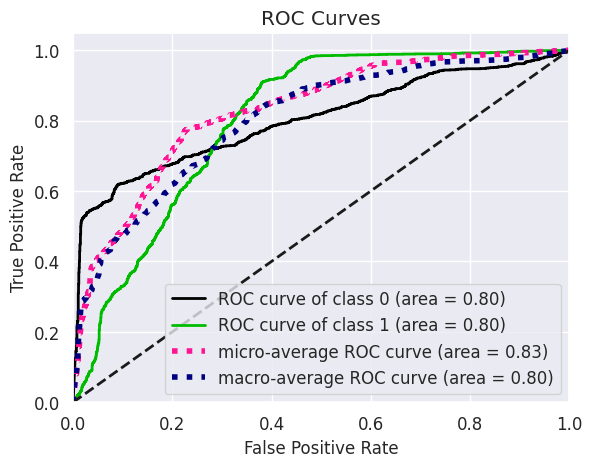

In [84]:
plot_roc(test_label, gnb.predict_proba(test_set_std))
plt.show()

In [85]:
# cross validation
scores = cross_validate(gnb, train_set_std, train_label, cv=3, return_train_score= True)
print('Fit time ', statistics.mean(scores['fit_time']))
print('Score time ', statistics.mean(scores['score_time']))
print('Test score ', statistics.mean(scores['test_score']))
print('Train score ', statistics.mean(scores['train_score']))

Fit time  0.010301987330118815
Score time  0.004735469818115234
Test score  0.7666045934202359
Train score  0.7679081315952825


### With min-max normalization

In [34]:
scaler_minmax = MinMaxScaler()

train_set_minmax = scaler_minmax.fit_transform(train_set.values)
test_set_minmax = scaler_minmax.fit_transform(test_set.values)

In [36]:
gnb_minmax = GaussianNB()
gnb_minmax.fit(train_set_minmax, train_label)

#predict on the test set
test_pred_gnb_minmax = gnb_minmax.predict(test_set_minmax)
train_pred_gnb_minmax = gnb_minmax.predict(train_set_minmax)

In [37]:
print_metrics(train_label, test_label, train_pred_gnb_minmax, test_pred_gnb_minmax)

Accuracy train set 0.7694599627560521
Accuracy test set 0.77208224732117
Precision train set 0.7821967554820207
Recall train set 0.7694599627560521
F1 score train set 0.7643664145694783
Support train set (array([0.83953241, 0.73165138]), array([0.62798092, 0.8941836 ]), array([0.71850841, 0.80479344]), array([3774, 4281]))


In [38]:
report_scores(test_label, test_pred_gnb_minmax)

              precision    recall  f1-score   support

        <=50       0.86      0.62      0.72      1618
         >50       0.73      0.91      0.81      1835

    accuracy                           0.77      3453
   macro avg       0.79      0.76      0.76      3453
weighted avg       0.79      0.77      0.77      3453



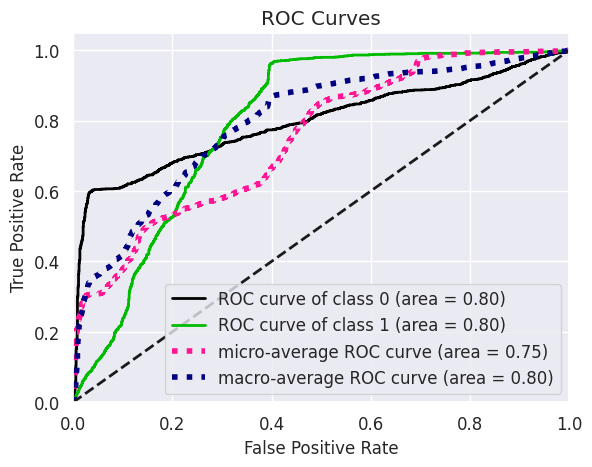

In [79]:
plot_roc(test_label, gnb.predict_proba(test_set_minmax))
plt.show()

# Classification with Random Forest (Random Hyperparameter Grid Search)

In [33]:
#to find the best set of parameter setting, we can run a grid search
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import RandomizedSearchCV
from sklearn.model_selection import GridSearchCV
from scipy.stats import randint as sp_randint
from sklearn.metrics import make_scorer
from sklearn.metrics import accuracy_score

In [35]:
#define the parameters' values you want to try
params = {  "max_depth": [2, 3, 5, 6, 7, 10],
            "max_features": ['log2', None],
            "min_samples_split": [2, 4, 6, 10],
            "min_samples_leaf": [1, 2, 3, 4],
            "bootstrap": [True, False],
            "criterion": ["entropy", "gini"],
            'n_estimators': np.arange(30, 120, 30),
         }

#define the model
clf = RandomForestClassifier()
#define the grid search
grid_search = GridSearchCV(
    clf, 
    params,
    cv = 3,
    verbose=1,
    n_jobs=-1,
    scoring='accuracy',
    return_train_score=False)
#run the grid search
grid_search.fit(train_set, train_label)
print("The best parameters are", grid_search.best_params_, ", score: %0.5f" % (grid_search.best_score_))

Fitting 3 folds for each of 2304 candidates, totalling 6912 fits
The best parameters are {'bootstrap': False, 'criterion': 'gini', 'max_depth': 10, 'max_features': 'log2', 'min_samples_leaf': 2, 'min_samples_split': 2, 'n_estimators': 90} , score: 0.85140


In [36]:
rf = grid_search.best_estimator_

In [37]:
#prediction on the test test
test_pred_rf = rf.predict(test_set)
train_pred_rf = rf.predict(train_set)

In [38]:
print_metrics(train_label, test_label, train_pred_rf, test_pred_rf)

Accuracy train set 0.8742396027312228
Accuracy test set 0.8459310744280336
Precision train set 0.8963092283365586
Recall train set 0.8742396027312228
F1 score train set 0.8713407823572886
Support train set (array([0.99321186, 0.8108828 ]), array([0.73661897, 0.99556178]), array([0.84588468, 0.89378211]), array([3774, 4281], dtype=int64))


In [39]:
#compute the performance of the model
report_scores(test_label, test_pred_rf)

              precision    recall  f1-score   support

     non-bot       0.97      0.69      0.81      1618
         bot       0.78      0.98      0.87      1835

    accuracy                           0.85      3453
   macro avg       0.88      0.84      0.84      3453
weighted avg       0.87      0.85      0.84      3453



c:\Users\domen\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\base.py:409: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(


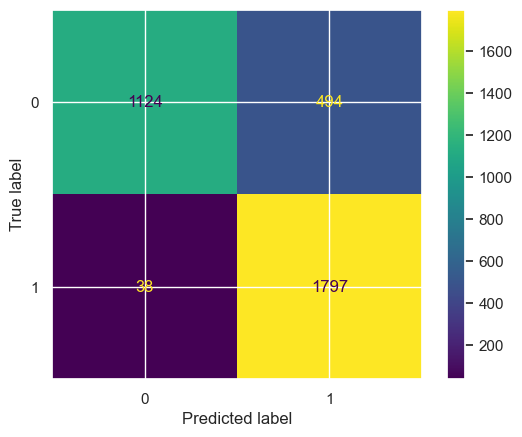

In [40]:
predictions = rf.predict(test_set.values)

cm = confusion_matrix(test_label, predictions)
disp = ConfusionMatrixDisplay(confusion_matrix = cm)
disp.plot()
plt.show()

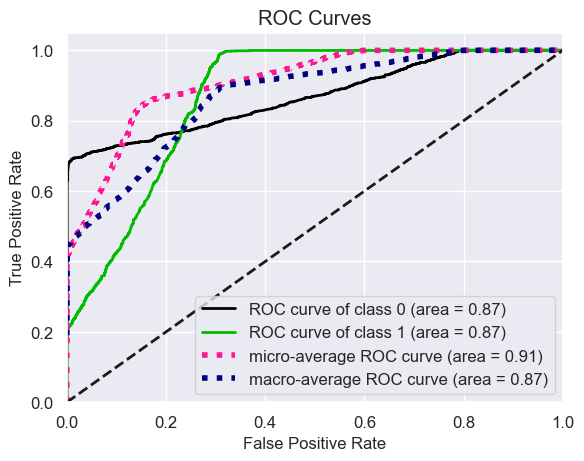

In [41]:
plot_roc(test_label, rf.predict_proba(test_set))
plt.show()

# AdaBoost

In [17]:
from sklearn.ensemble import AdaBoostClassifier

In [18]:
#define the parameters' values you want to try
params = {  "n_estimators": np.arange(30, 500, 10),
            "learning_rate": np.arange(0.4, 2, 0.1),
            "algorithm": ['SAMME', 'SAMME.R'],
         }

#define the model
ada_tree = AdaBoostClassifier()
#define the grid search
grid_search = GridSearchCV(
    ada_tree, 
    params,
    cv = 3,
    verbose=1,
    n_jobs=-1,
    scoring='accuracy',
    return_train_score=False)
#run the grid search
grid_search.fit(train_set, train_label)
print("The best parameters are", grid_search.best_params_, ", score: %0.5f" % (grid_search.best_score_))

Fitting 3 folds for each of 1504 candidates, totalling 4512 fits
The best parameters are {'algorithm': 'SAMME.R', 'learning_rate': 0.7, 'n_estimators': 200} , score: 0.84718


In [19]:
ada= grid_search.best_estimator_

In [20]:
test_pred_ada = ada.predict(test_set)
train_pred_ada = ada.predict(train_set)

In [21]:
print_metrics(train_label, test_label, train_pred_ada, test_pred_ada)

Accuracy train set 0.85747982619491
Accuracy test set 0.8427454387489139
Precision train set 0.8787212444421862
Recall train set 0.85747982619491
F1 score train set 0.8541312172763296
Support train set (array([0.97094692, 0.79741788]), array([0.7172761 , 0.98107919]), array([0.82505334, 0.8797654 ]), array([3774, 4281], dtype=int64))


In [22]:
report_scores(test_label, test_pred_ada)

              precision    recall  f1-score   support

     non-bot       0.95      0.70      0.81      1618
         bot       0.78      0.97      0.87      1835

    accuracy                           0.84      3453
   macro avg       0.87      0.83      0.84      3453
weighted avg       0.86      0.84      0.84      3453



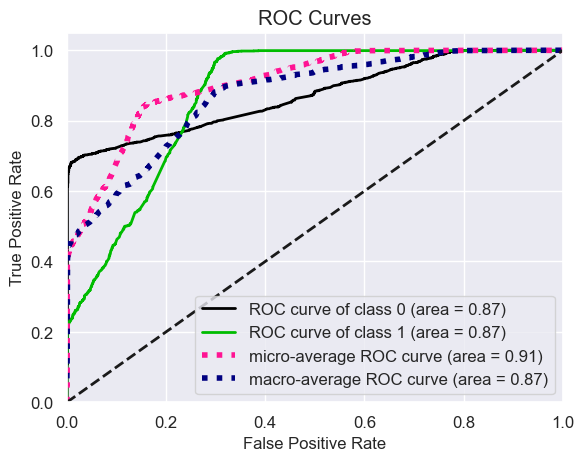

In [23]:
plot_roc(test_label, ada.predict_proba(test_set))
plt.show()

# Classification with KNN

In [53]:
#drop the categorical features
train_set_no_cat = train_set.loc[:,~train_set.columns.str.contains('_num', case=False)]
test_set_no_cat = test_set.loc[:,~test_set.columns.str.contains('_num', case=False)]

In [72]:
from sklearn.neighbors import KNeighborsClassifier

train_set_std = scaler.fit_transform(train_set_no_cat.values)
test_set_std = scaler.fit_transform(test_set_no_cat.values)

In [73]:
params = {
    "n_neighbors": np.arange(1, 20, 1),
    "weights": ['uniform', 'distance'],
    "algorithm": ['auto', 'ball_tree', 'kd_tree', 'brute'],
}

knn = KNeighborsClassifier()

grid_search = GridSearchCV(
    knn,
    params,
    cv=3,
    scoring='accuracy',
    return_train_score=False,
    n_jobs=-1,
    verbose=1
)

grid_search.fit(train_set_std, train_label)
print("The best parameters are", grid_search.best_params_, ", score: %0.5f" % (grid_search.best_score_))

Fitting 3 folds for each of 152 candidates, totalling 456 fits
The best parameters are {'algorithm': 'auto', 'n_neighbors': 17, 'weights': 'uniform'} , score: 0.80782


In [74]:
knn = grid_search.best_estimator_

In [75]:
#prediction on the test test
test_pred_knn = knn.predict(test_set_std)
train_pred_knn = knn.predict(train_set_std)

In [76]:
print_metrics(train_label, test_label, train_pred_knn, test_pred_knn)

Accuracy train set 0.8183736809435134
Accuracy test set 0.806545033304373
Precision train set 0.8454465660536186
Recall train set 0.8183736809435134
F1 score train set 0.81260641563825
Support train set (array([0.94425221, 0.7583425 ]), array([0.65076842, 0.96612941]), array([0.7705098 , 0.84971751]), array([3774, 4281]))


In [77]:
#compute the performance of the model
report_scores(test_label, test_pred_knn)

              precision    recall  f1-score   support

        <=50       0.94      0.63      0.75      1618
         >50       0.75      0.96      0.84      1835

    accuracy                           0.81      3453
   macro avg       0.84      0.80      0.80      3453
weighted avg       0.84      0.81      0.80      3453



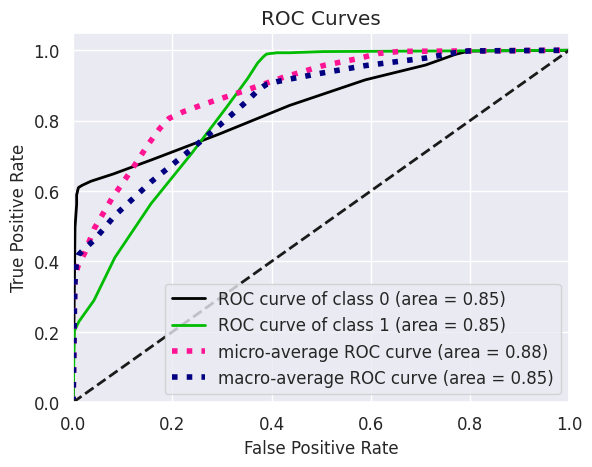

In [78]:
plot_roc(test_label, knn.predict_proba(test_set_std))
plt.show()

# Classification with SVM

In [62]:
from sklearn.svm import SVC
train_set_std = scaler.fit_transform(train_set.values)
test_set_std = scaler.fit_transform(test_set.values)

In [63]:
params = {
    'kernel':('linear', 'rbf', 'poly', 'sigmoid'), 
    'C':[0.01, 0.1, 1, 10, 100],
    'degree': [2, 3, 4],
    'gamma': ['scale', 'auto']
}

svm = SVC(probability=True)

grid_search = GridSearchCV(
    svm,
    params,
    cv=3,
    scoring='accuracy',
    return_train_score=False,
    n_jobs=-1,
    verbose=1
)

grid_search.fit(train_set_std, train_label)

Fitting 3 folds for each of 120 candidates, totalling 360 fits


GridSearchCV(cv=3, estimator=SVC(probability=True), n_jobs=-1,
             param_grid={'C': [0.01, 0.1, 1, 10, 100], 'degree': [2, 3, 4],
                         'gamma': ['scale', 'auto'],
                         'kernel': ('linear', 'rbf', 'poly', 'sigmoid')},
             scoring='accuracy', verbose=1)

In [64]:
svm = grid_search.best_estimator_

In [65]:
test_pred_svm = svm.predict(test_set_std)
train_pred_svm = svm.predict(train_set_std)

In [66]:
print_metrics(train_label, test_label, train_pred_svm, test_pred_svm)

Accuracy train set 0.8698944754810677
Accuracy test set 0.8381117868520127
Precision train set 0.8923744544743788
Recall train set 0.8698944754810677
F1 score train set 0.8668163451331747
Support train set (array([0.98958333, 0.80667805]), array([0.7299947 , 0.99322588]), array([0.84019518, 0.89028476]), array([3774, 4281]))


In [67]:
#compute the performance of the model
report_scores(test_label, test_pred_svm)

              precision    recall  f1-score   support

        <=50       0.96      0.68      0.80      1618
         >50       0.78      0.97      0.86      1835

    accuracy                           0.84      3453
   macro avg       0.87      0.83      0.83      3453
weighted avg       0.86      0.84      0.83      3453



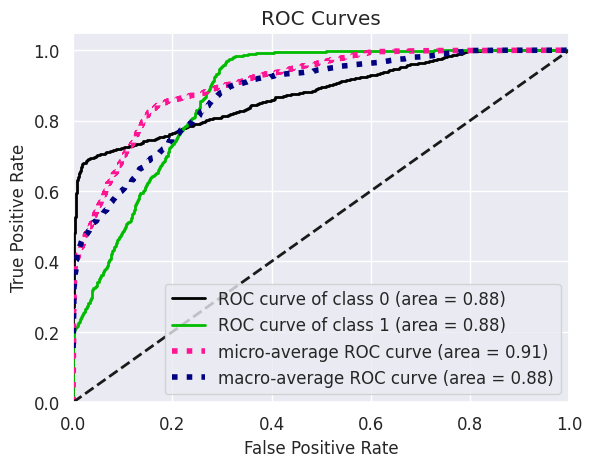

In [69]:
plot_roc(test_label, svm.predict_proba(test_set_std))
plt.show()

# Classification with neural network

In [ ]:
params = {
    'kernel':('linear', 'rbf', 'poly', 'sigmoid'), 
    'C':[0.01, 0.1, 1, 10, 100],
    'degree': [2, 3, 4],
    'gamma': ['scale', 'auto']
}

nn = SVC(probability=True)

grid_search = GridSearchCV(
    svm,
    params,
    cv=3,
    scoring='accuracy',
    return_train_score=False,
    n_jobs=-1,
    verbose=1
)

grid_search.fit(train_set_std, train_label)

# ROC Curve

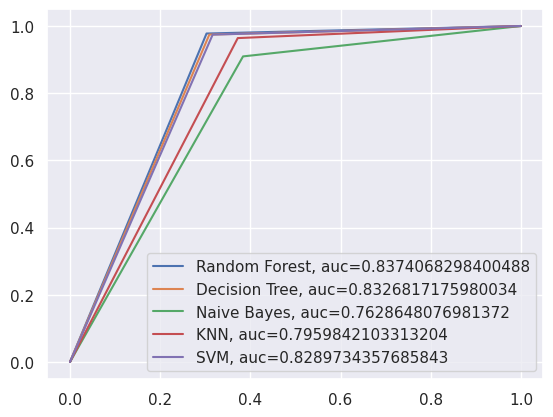

In [70]:
from sklearn import metrics
import numpy as np
import matplotlib.pyplot as plt

plt.figure(0).clf()

#fpr, tpr, thresh = metrics.roc_curve(test_label, test_pred_clf)
#auc = metrics.roc_auc_score(test_label, test_pred_clf)
#plt.plot(fpr,tpr,label="AdaBoost, auc="+str(auc))

fpr, tpr, thresh = metrics.roc_curve(test_label, test_pred_rf)
auc = metrics.roc_auc_score(test_label, test_pred_rf)
plt.plot(fpr,tpr,label="Random Forest, auc="+str(auc))

fpr, tpr, thresh = metrics.roc_curve(test_label, test_pred_dt)
auc = metrics.roc_auc_score(test_label, test_pred_dt)
plt.plot(fpr,tpr,label="Decision Tree, auc="+str(auc))

fpr, tpr, thresh = metrics.roc_curve(test_label, test_pred_gnb)
auc = metrics.roc_auc_score(test_label, test_pred_gnb)
plt.plot(fpr,tpr,label="Naive Bayes, auc="+str(auc))

fpr, tpr, thresh = metrics.roc_curve(test_label, test_pred_knn)
auc = metrics.roc_auc_score(test_label, test_pred_knn)
plt.plot(fpr,tpr,label="KNN, auc="+str(auc))

fpr, tpr, thresh = metrics.roc_curve(test_label, test_pred_svm)
auc = metrics.roc_auc_score(test_label, test_pred_svm)
plt.plot(fpr,tpr,label="SVM, auc="+str(auc))

#fpr, tpr, thresh = metrics.roc_curve(test_label, test_pred_nn)
#auc = metrics.roc_auc_score(test_label, test_pred_nn)
#plt.plot(fpr,tpr,label="NN, auc="+str(auc))

plt.legend(loc=0)